# Computing Fama-French Factor Regressions

Name: Engineer Investor (@egr_investor)

Date: 04/09/24

In this tutorial, we will learn how to compute the Fama-French five-factor model regressions for stock ETFs and mutual funds using Python. The Fama-French five-factor model is an asset pricing model that expands on the CAPM to include size, value, profitability, and investment factors in addition to the market risk factor. We abbreviate the factors in the the Fama-French five factor model with market, size, value, profitability, and investment factors as MKT, SMB, HML, RMW, CMA, respectively. According to Portfolio Visualizer, the multiple linear regression indicates how well the returns of the given assets or a portfolio are explained by the risk factor exposures.

We'll also learn how to download the factor data from Ken French’s website using Python, and use the yfinance API to get stock ETF and mutual fund data. Finally, we will perform the regressions and plot the results.

Source:  https://www.portfoliovisualizer.com/factor-analysis

## Fama-French Five Factor Model

The Fama-French five-factor model is an extension of the Fama-French three-factor model, including two additional factors to better explain the returns of stocks. It can be represented as follows:


$R_{i,t} - R_{f,t} = \alpha_i + \beta_{mkt}(R_{mkt,t} - R_{f,t}) + \beta_{SMB}SMB_t + \beta_{HML}HML_t + \beta_{RMW}RMW_t + \beta_{CMA}CMA_t + \epsilon_{i,t}$

Where:

- $R_{i,t} - R_{f,t}$ is the excess return of asset $i$ at time $t$ over the risk-free rate.
- $\alpha_i$ is the asset's alpha or abnormal return that cannot be explained by the model.
- $\beta_{mkt}$, $\beta_{SMB}$, $\beta_{HML}$, $\beta_{RMW}$, and $\beta_{CMA}$ are the sensitivities of the excess return to the respective factors.
- $R_{mkt,t} - R_{f,t}$ is the market excess return at time $t$.
- $SMB_t$ (Small Minus Big) is the size premium, or the return on a portfolio of small stocks minus the return on a portfolio of big stocks.
- $HML_t$ (High Minus Low) is the value premium, or the return on a portfolio of high book-to-market stocks minus the return on a portfolio of low book-to-market stocks.
- $RMW_t$ (Robust Minus Weak) is the profitability premium, or the return on a portfolio of stocks with robust (high) operating profitability minus the return on a portfolio of stocks with weak (low) operating profitability.
- $CMA_t$ (Conservative Minus Aggressive) is the investment factor, or the return on a portfolio of stocks of companies with conservative investment policies minus the return on a portfolio of stocks of companies with aggressive investment policies.
- $\epsilon_{i,t}$ is the error term or idiosyncratic risk of asset $i$ at time $t$.

Descriptions of each factor: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library/f-f_factors.html

## Step 1: Setting Up Your Environment
First, ensure you have Python installed on your system. Then, you need to install the necessary libraries. You can do this by running the following command:

In [207]:
!pip install yfinance pandas numpy statsmodels matplotlib

In [208]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
import pickle
import os

## Step 2: Downloading Factor Data

Ken French’s website provides historical factor data which we can use for our analysis. In this tutorial, we will only use U.S. equity factor data, but you can modify the code to download ex-U.S. or other asset factor data. We'll write a Python function to download this data:

In [209]:
def download_ff_factors():
    url = "http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_daily_CSV.zip"
    factors = pd.read_csv(url, skiprows=3, index_col=0, parse_dates=True)
    factors = factors.loc[factors.index != '']
    factors.index = pd.to_datetime(factors.index, format='%Y%m%d')
    factors = factors.apply(pd.to_numeric, errors='coerce').dropna()
    factors.columns = ['Market', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
    return factors

In [210]:
# Functions to save and load df to Pickle
def save_df_to_pickle(df, filename):
  with open(filename, 'wb') as f:
    pickle.dump(df, f)

In [211]:
def load_df_from_pickle(filename):
  with open(filename, 'rb') as f:
    df = pickle.load(f)
  return df

In [212]:
# Check if the file exists
if os.path.isfile('factors_FF5.pkl'):
    # If the file exists, load the dataframe to pickle
    factors = load_df_from_pickle('factors_FF5.pkl')

    print('Found saved file.')
else:
    factors = download_ff_factors()

    # If the file does not exist, save the dataframe to pickle
    save_df_to_pickle(factors, 'factors_FF5.pkl')

Found saved file.


### View the factor data

In [213]:
factors

,Market,SMB,HML,RMW,CMA,RF
1963-07-01,-0.67,0.02,-0.35,0.03,0.13,0.012
1963-07-02,0.79,-0.28,0.28,-0.08,-0.21,0.012
1963-07-03,0.63,-0.18,-0.10,0.13,-0.25,0.012
1963-07-05,0.40,0.09,-0.28,0.07,-0.30,0.012
1963-07-08,-0.63,0.07,-0.20,-0.27,0.06,0.012
...,...,...,...,...,...,...
2024-02-23,0.02,0.32,-0.03,0.09,-0.11,0.021
2024-02-26,-0.26,0.97,-0.11,-0.74,-0.01,0.021
2024-02-27,0.27,1.24,-0.45,-1.14,0.67,0.021
2024-02-28,-0.26,-0.90,0.00,-0.05,0.53,0.021


<Figure size 640x480 with 0 Axes>

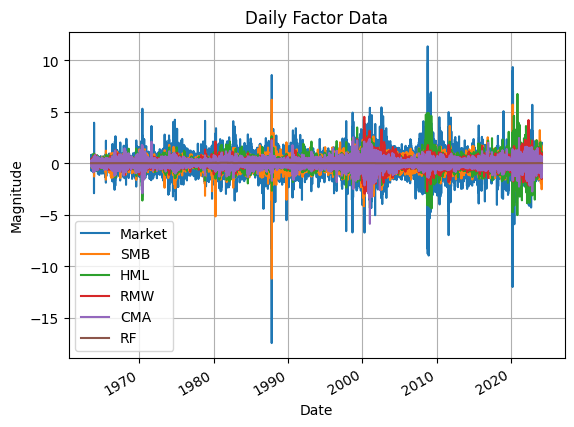

In [214]:
plt.figure()
factors.plot()
plt.title('Daily Factor Data')
plt.xlabel('Date')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

## Step 3: Getting Stock ETF and Mutual Fund Data

We will use the yfinance library to download historical stock prices. Replace 'AAPL' with the ticker symbol of the ETF or mutual fund you are interested in.

In [215]:
# Get today's date
from datetime import date

today = date.today()
today_formatted_date = today.strftime('%Y-%m-%d')
print(today_formatted_date)

2024-04-10


In [216]:
ticker = 'DFSVX'
start_date = '1990-01-01'
end_date = today_formatted_date

In [217]:
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data['Adj Close']

stock_data = get_stock_data(ticker, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


Note: This tutorial uses the adjusted close price, which is the closing price of the ticker after adjustments for all applicable splits and dividend distributions. Data is adjusted using appropriate split and dividend multipliers, adhering to Center for Research in Security Prices (CRSP) standards.

Source: https://help.yahoo.com/kb/SLN28256.html

In [218]:
first_date = stock_data.index[0].date().strftime('%m-%d-%Y')
last_date = stock_data.index[-1].date().strftime('%m-%d-%Y')

print(ticker + ' stock data from ' + first_date + ' to ' + last_date + '.')

DFSVX stock data from 02-26-1993 to 04-09-2024.


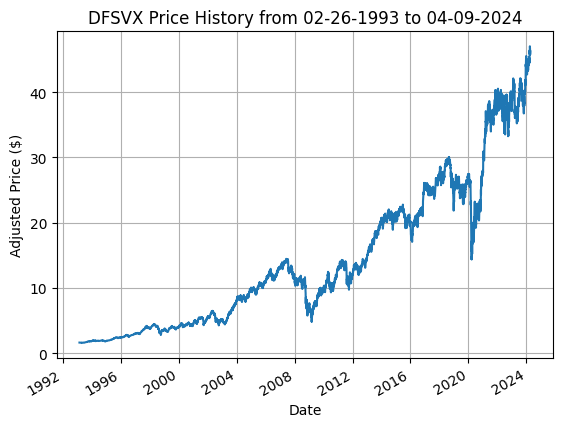

In [219]:
plt.figure()
stock_data.plot()
plt.title(ticker + ' Price History from ' + first_date + ' to ' + last_date)
plt.ylabel('Adjusted Price ($)')
plt.grid(True)
plt.show()

## Step 4: Preparing the Data

Before running the regression, we need to prepare our data. This includes aligning the dates of the stock data and the factor data, and calculating excess returns (stock returns minus the risk-free rate).

In [220]:
excess_returns = stock_data.pct_change().dropna() - factors['RF']
aligned_data = pd.concat([excess_returns, factors], axis=1, join='inner').dropna()

# Step 5: Running the Regression

We use the statsmodels library to run the regression, using the market factor, SMB, HML, RMW, and CMA as independent variables, and the stock's excess returns as the dependent variable.

Th block of code below performs a linear regression analysis using the Fama-French five-factor model on a dataset that includes the excess returns of a stock (or ETF, mutual fund, etc.) and the Fama-French factors. Here’s a step-by-step breakdown of what each part does:

1. **Selecting the Dependent and Independent Variables:**
   - `Y = aligned_data.iloc[:, 0]`: This line selects the first column of `aligned_data`, which contains the excess returns of the stock. Excess returns are the returns of the stock minus the risk-free rate. This is set as the dependent variable `Y` for the regression analysis. The dependent variable is what you are trying to predict or explain.
   - `X = aligned_data.iloc[:, 1:-1]`: This line selects all columns from the second to the second-to-last of `aligned_data`, excluding the last one (`RF`, the risk-free rate) since it was already used to calculate excess returns. These columns represent the independent variables in the Fama-French five-factor model, namely: Market Risk Premium (`Market`), Small Minus Big (`SMB`), High Minus Low (`HML`), Robust Minus Weak (`RMW`), and Conservative Minus Aggressive (`CMA`). These independent variables are the factors that are hypothesized to explain the variability in stock returns.

2. **Adding a Constant to the Model:**
   - `X = sm.add_constant(X)`: This line adds a column of ones to the `X` DataFrame, effectively adding a constant term to the regression model. This is important because it allows the regression model to include an intercept term. Without this constant, the regression line would be forced to pass through the origin (0,0), which is not desired in most cases.

3. **Creating and Fitting the Regression Model:**
   - `model = sm.OLS(Y, X).fit()`: This line creates a linear regression model using Ordinary Least Squares (OLS) with `Y` as the dependent variable and `X` as the independent variables (including the constant term). The `.fit()` method is then called to fit the model to the data. This process involves finding the coefficients (also known as parameters or betas) that minimize the sum of the squared differences between the observed values and the values predicted by the linear model.

4. **Outputting the Model Summary:**
   - `print(model.summary())`: This line prints a summary of the regression model to the console. The summary includes several important pieces of information, such as the regression coefficients for each independent variable (which indicate the strength and direction of the relationship between each factor and the stock returns), the R-squared value (which measures the proportion of the variance in the dependent variable that is predictable from the independent variables), and various statistical tests and values that can help assess the quality and validity of the model.

In summary, this code is used to understand how well the Fama-French five-factor model explains the returns of a specific stock (or ETF, mutual fund, etc.) by analyzing the relationship between the stock's excess returns and the five factors. It helps in identifying which factors are significant predictors of the stock's returns and how strong these relationships are.

In [221]:
Y = aligned_data.iloc[:, 0]  # Excess returns of the stock
X = aligned_data.iloc[:, 1:-1]  # Independent factors excluding RF
X = sm.add_constant(X)  # Adds a constant term to the predictor

model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     3760.
Date:                Wed, 10 Apr 2024   Prob (F-statistic):               0.00
Time:                        03:37:39   Log-Likelihood:                 25933.
No. Observations:                7807   AIC:                        -5.185e+04
Df Residuals:                    7801   BIC:                        -5.181e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0090   9.91e-05    -91.138      0.0

Comparison with Portfolio Visualizer's factor regression: https://www.portfoliovisualizer.com/factor-analysis?s=y&sl=50BSmAW0sOxUksJp0Q60I9

See the Portfolio Visualizer's Methodology section for more information on computing factor regressions: https://www.portfoliovisualizer.com/faq#

# Step 6: Plotting the Results

We can plot the factor sensitivities (betas) to visually analyze the impact of each factor on the stock's returns.

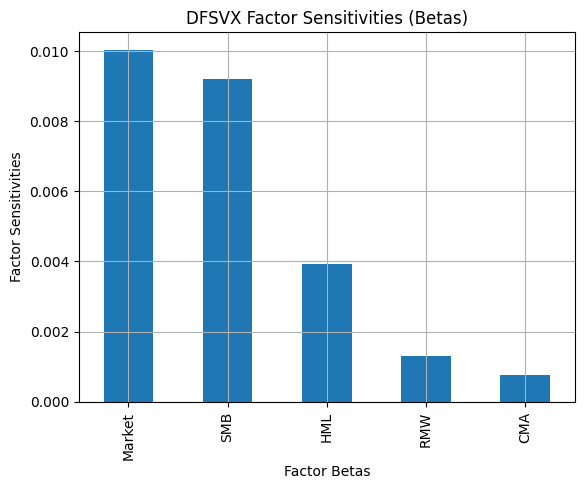

In [222]:
betas = model.params[1:]  # Exclude the constant
betas.plot(kind='bar')
plt.title(ticker + ' Factor Sensitivities (Betas)')
plt.ylabel('Factor Sensitivities')
plt.xlabel('Factor Betas')
plt.grid(True)
plt.show()

# Conclusion

This concludes our tutorial on computing the Fama-French five-factor model regressions for stock ETFs and mutual funds using Python. By following these steps, you can analyze the impact of different risk factors on the returns of any stock, ETF, or mutual fund.